In [1]:
%matplotlib inline


# Univariate Feature Selection


An example showing univariate feature selection.

Noisy (non informative) features are added to the iris data and
univariate feature selection is applied. For each feature, we plot the
p-values for the univariate feature selection and the corresponding
weights of an SVM. We can see that univariate feature selection
selects the informative features and that these have larger SVM weights.

In the total set of features, only the 4 first ones are significant. We
can see that they have the highest score with univariate feature
selection. The SVM assigns a large weight to one of these features, but also
Selects many of the non-informative features.
Applying univariate feature selection before the SVM
increases the SVM weight attributed to the significant features, and will
thus improve classification.


In [2]:
print(__doc__)

# Common imports
import numpy as np
import numpy.random as rnd
import os
import pandas as pd

# To make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Show all columns when displaying dataframes
pd.set_option('display.max_columns', None)

from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif

Automatically created module for IPython interactive environment


import some data to play with


In [3]:
csv_path = 'MIMIC II/DIAGNOSES_ICD.csv'
diagnoses = pd.read_csv(csv_path) #done

csv_path = 'MIMIC II/D_ICD_DIAGNOSES.csv'
dir_diagnoses = pd.read_csv(csv_path) #done

csv_path = 'MIMIC II/PATIENTS.csv'
patients = pd.read_csv(csv_path) #done

csv_path = 'MIMIC II/ADMISSIONS.csv'
admissions = pd.read_csv(csv_path)
admissions.fillna('NoData', inplace = True)
admissions = admissions.applymap(str) #done

csv_path = 'MIMIC II/DRGCODES.csv'
drugcodes = pd.read_csv(csv_path)


In [4]:
diagnoses = diagnoses.drop(['ROW_ID', 'SEQ_NUM'], axis = 1)
drugcodes = drugcodes.drop(['ROW_ID', 'DRG_TYPE', 'DRG_SEVERITY', 'DRG_MORTALITY', 'DESCRIPTION'], axis = 1)
patients = patients.drop(['ROW_ID', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN'], axis = 1)
dir_diagnoses = dir_diagnoses.drop(['ROW_ID', 'LONG_TITLE'], axis = 1)
admissions = admissions.drop(['ROW_ID', 'DISCHTIME', 'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG', 'DEATHTIME', 'ADMISSION_TYPE', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'HAS_CHARTEVENTS_DATA'], axis = 1)

In [5]:
diagnoses_new = pd.merge(diagnoses, dir_diagnoses, on = 'ICD9_CODE')
diagnoses_new = diagnoses_new.drop('ICD9_CODE', axis = 1)
diagnoses_new.columns = ['SUBJECT_ID', 'HADM_ID', 'DIAGNOSES_SHORT_TITLE']
print(diagnoses_new.head())
diagnoses_new.info()

   SUBJECT_ID  HADM_ID   DIAGNOSES_SHORT_TITLE
0         109   172335  Mal hyp kid w cr kid V
1         109   173633  Mal hyp kid w cr kid V
2         109   131345  Mal hyp kid w cr kid V
3         109   131376  Mal hyp kid w cr kid V
4         109   135923  Mal hyp kid w cr kid V
<class 'pandas.core.frame.DataFrame'>
Int64Index: 634709 entries, 0 to 634708
Data columns (total 3 columns):
SUBJECT_ID               634709 non-null int64
HADM_ID                  634709 non-null int64
DIAGNOSES_SHORT_TITLE    634709 non-null object
dtypes: int64(2), object(1)
memory usage: 19.4+ MB


In [6]:
word_list = ['EMERGENCY ROOM ADMIT']
admissions = admissions[admissions['ADMISSION_LOCATION'].str.contains('|'.join(word_list))]

word_list = ['STROKE', 'CVA', 'CEREBROVASCULAR ACCIDENT']
STROKE_diagnosis = admissions[admissions['DIAGNOSIS'].str.contains('|'.join(word_list))]
    #836 TOTAL STROKE
word_list = ['TIA', 'TRANSIENT ISCHEMIC ATTACK']
TIA_diagnosis = STROKE_diagnosis[STROKE_diagnosis['DIAGNOSIS'].str.contains('|'.join(word_list))]
    #560 TOTAL TIA
word_list = TIA_diagnosis['SUBJECT_ID'].tolist()
STROKE_diagnosis = STROKE_diagnosis.set_index(STROKE_diagnosis['SUBJECT_ID'])
ISCHEMIC_STROKE_diagnosis = STROKE_diagnosis.drop(word_list)
    #458 TOTAL ISCHEMIC STROKE (309 emergency room admit)
ISCHEMIC_STROKE_diagnosis = ISCHEMIC_STROKE_diagnosis.drop(['ADMITTIME', 'ADMISSION_LOCATION'], axis = 1)

In [7]:
admissions = admissions.drop(['DIAGNOSIS', 'ADMISSION_LOCATION'], axis = 1)

In [8]:
#lets get the dates into weekdays
import datetime

admTime = admissions['ADMITTIME']

def get_day_of_week (value):
    date = []
    int_date = []
    day_of_week = []
    
    #replace dashes and colons with spaces to make breaking the string up easier
    value = value.replace('-', ' ')
    value = value.replace(':', ' ')
    
    #split into a string outputting [year, month, day, hour, minutes, seconds]
    date = value.split(' ')
    
    #delete hour/min/sec, convert to integers
    del date[3:6]
    int_date = [int(i) for i in date]
    
    #get day of week and return it
    day_of_week = datetime.date(int_date[0], int_date[1], int_date[2]).weekday()
    
    return day_of_week


admTime_weekday = [get_day_of_week(value) for value in admTime]

weekday_data = pd.DataFrame({'ADM_DAY' : admTime_weekday})
admissions = pd.concat([admissions, weekday_data], axis=1)
admissions = admissions.drop('ADMITTIME', axis = 1)
admissions = admissions.dropna()
admissions.head()

,SUBJECT_ID,HADM_ID,ADM_DAY
0,22,165315,5.0
4,25,129635,3.0
11,33,176176,5.0
16,36,122659,3.0
18,37,188670,6.0


In [9]:
patients.head()

,SUBJECT_ID,GENDER,EXPIRE_FLAG
0,249,F,0
1,250,F,1
2,251,M,0
3,252,M,0
4,253,F,0


In [10]:
drugcodes.head()

,SUBJECT_ID,HADM_ID,DRG_CODE
0,2491,144486,28
1,24958,162910,110
2,18325,153751,390
3,17887,182692,14
4,11113,157980,390


In [11]:
ISCHEMIC_STROKE_diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 360 to 91733
Data columns (total 3 columns):
SUBJECT_ID    309 non-null object
HADM_ID       309 non-null object
DIAGNOSIS     309 non-null object
dtypes: object(3)
memory usage: 9.7+ KB


In [12]:
admissions = admissions.applymap(str)
patients = patients.applymap(str)
drugcodes = drugcodes.applymap(str)
ISCHEMIC_STROKE_diagnosis = ISCHEMIC_STROKE_diagnosis.applymap(str)

In [13]:
df1 = pd.merge(admissions, patients, on = 'SUBJECT_ID')
df1.head()

,SUBJECT_ID,HADM_ID,ADM_DAY,GENDER,EXPIRE_FLAG
0,22,165315,5.0,F,0
1,25,129635,3.0,M,0
2,33,176176,5.0,M,0
3,36,122659,3.0,M,0
4,37,188670,6.0,M,1


In [14]:
df2 = pd.merge(df1, drugcodes, on = ['SUBJECT_ID', 'HADM_ID'])
df2.head()

,SUBJECT_ID,HADM_ID,ADM_DAY,GENDER,EXPIRE_FLAG,DRG_CODE
0,22,165315,5.0,F,0,450
1,25,129635,3.0,M,0,526
2,33,176176,5.0,M,0,416
3,36,122659,3.0,M,0,439
4,36,122659,3.0,M,0,7912


In [15]:
df3 = pd.merge(df2, ISCHEMIC_STROKE_diagnosis, on = ['SUBJECT_ID', 'HADM_ID'])
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 194
Data columns (total 7 columns):
SUBJECT_ID     195 non-null object
HADM_ID        195 non-null object
ADM_DAY        195 non-null object
GENDER         195 non-null object
EXPIRE_FLAG    195 non-null object
DRG_CODE       195 non-null object
DIAGNOSIS      195 non-null object
dtypes: object(7)
memory usage: 12.2+ KB


In [16]:
Xdf = df3[['DIAGNOSIS', 'ADM_DAY', 'GENDER', 'DRG_CODE']].copy()
Xdf = pd.get_dummies(Xdf)
X = Xdf.as_matrix()

y = df3[['EXPIRE_FLAG']].copy()
y = y.as_matrix()

In [17]:
column_titles = list(Xdf)
value_map = []
for value in range(len(column_titles)):
    x = column_titles[value], value
    value_map.append(x)
value_map

[('DIAGNOSIS_? CVA', 0),
 ('DIAGNOSIS_ACUTE CVA', 1),
 ('DIAGNOSIS_ACUTE CVA;TELEMETRY', 2),
 ('DIAGNOSIS_ACUTE LEFT CEREBRAL VASSCULAR ACCIDENT ISCHEMIC STROKE', 3),
 ('DIAGNOSIS_ACUTE STROKE', 4),
 ('DIAGNOSIS_ACUTE STROKE;TELEMETRY', 5),
 ('DIAGNOSIS_BRAIN STEM CVA', 6),
 ('DIAGNOSIS_CEREBELLAR STROKE', 7),
 ('DIAGNOSIS_CEREBROVASCULAR ACCIDENT', 8),
 ('DIAGNOSIS_CEREBROVASCULAR ACCIDENT-RT HEMIPARESIS', 9),
 ('DIAGNOSIS_CEREBROVASCULAR ACCIDENT;FEV', 10),
 ('DIAGNOSIS_CEREBROVASCULAR ACCIDENT;SUBDURAL BLEED;TELEMETRY', 11),
 ('DIAGNOSIS_CEREBROVASCULAR ACCIDENT;TELEMETRY', 12),
 ('DIAGNOSIS_CVA', 13),
 ('DIAGNOSIS_CVA VS.SEIZURES', 14),
 ('DIAGNOSIS_CVA;HYPOTENSION', 15),
 ('DIAGNOSIS_CVA;TELEMETRY', 16),
 ('DIAGNOSIS_DIABETIC KETOACIDOSIS;CVA;FEVER,ETIOLOGY UNKNOWN', 17),
 ('DIAGNOSIS_HEMMO-HAGIC STROKE', 18),
 ('DIAGNOSIS_HEMORRAGIC STROKE;TELEMETRY', 19),
 ('DIAGNOSIS_HEMORRHAGE STROKE', 20),
 ('DIAGNOSIS_HEMORRHAGIC CVA', 21),
 ('DIAGNOSIS_HEMORRHAGIC CVA;TELEMETRY', 22),
 ('DI

In [18]:
plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])
X_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109])

Univariate feature selection with F-test for feature scoring
We use the default selection function: the 10% most significant features


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Container object of 110 artists>

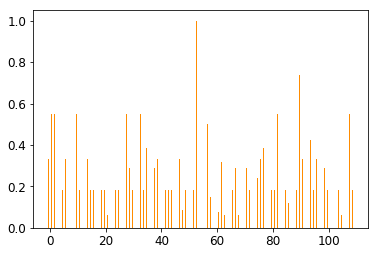

In [19]:
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')

In [20]:
score_map = []
for x in range(len(scores)):
    x = column_titles[x], scores[x]
    score_map.append(x)
score_map
'''
('ADM_DAY_0.0', 0.13418842234031289),
('ADM_DAY_1.0', 0.4994227619049853),
('ADM_DAY_2.0', 0.15037857397140769),
('ADM_DAY_3.0', 0.0056352821179760804),
('ADM_DAY_4.0', 0.0093515519395716822),
('ADM_DAY_5.0', 0.075274163793145041),
('ADM_DAY_6.0', 0.31793826550092569),
('GENDER_F', 0.060521920955894558),
('GENDER_M', 0.060521920955894558),
('DRG_CODE_12', 0.28830929328263438),
('DRG_CODE_14', 0.33564775541486708),
('DRG_CODE_15', 0.28830929328263438),
('DRG_CODE_20', 0.33064811423027091),
('DRG_CODE_24', 0.23991117135728041),
('DRG_CODE_263', 0.33064811423027091),
('DRG_CODE_28', 0.38408383504914417),
('DRG_CODE_442', 0.54884975340964048),
('DRG_CODE_454', 0.28902143056131591),
('DRG_CODE_468', 0.73723455768875967),
('DRG_CODE_478', 0.33064811423027091),
('DRG_CODE_5', 0.42344706980199209)
('DRG_CODE_533', 0.33064811423027091)
('DRG_CODE_576', 0.33064811423027091),
('DRG_CODE_582', 0.33064811423027091),
('DRG_CODE_7203', 0.33064811423027091),
('DRG_CODE_8', 0.54884975340964048),
'''

"\n('ADM_DAY_0.0', 0.13418842234031289),\n('ADM_DAY_1.0', 0.4994227619049853),\n('ADM_DAY_2.0', 0.15037857397140769),\n('ADM_DAY_3.0', 0.0056352821179760804),\n('ADM_DAY_4.0', 0.0093515519395716822),\n('ADM_DAY_5.0', 0.075274163793145041),\n('ADM_DAY_6.0', 0.31793826550092569),\n('GENDER_F', 0.060521920955894558),\n('GENDER_M', 0.060521920955894558),\n('DRG_CODE_12', 0.28830929328263438),\n('DRG_CODE_14', 0.33564775541486708),\n('DRG_CODE_15', 0.28830929328263438),\n('DRG_CODE_20', 0.33064811423027091),\n('DRG_CODE_24', 0.23991117135728041),\n('DRG_CODE_263', 0.33064811423027091),\n('DRG_CODE_28', 0.38408383504914417),\n('DRG_CODE_442', 0.54884975340964048),\n('DRG_CODE_454', 0.28902143056131591),\n('DRG_CODE_468', 0.73723455768875967),\n('DRG_CODE_478', 0.33064811423027091),\n('DRG_CODE_5', 0.42344706980199209)\n('DRG_CODE_533', 0.33064811423027091)\n('DRG_CODE_576', 0.33064811423027091),\n('DRG_CODE_582', 0.33064811423027091),\n('DRG_CODE_7203', 0.33064811423027091),\n('DRG_CODE_8', 

In [21]:
pvalue_map = []
for x in range(len(selector.pvalues_)):
    x = column_titles[x], selector.pvalues_[x]
    pvalue_map.append(x)
''' 
 ('ADM_DAY_0.0', 0.53250773817559804),
 ('ADM_DAY_1.0', 0.095816262411387423),
 ('ADM_DAY_2.0', 0.49352197616153592),
 ('ADM_DAY_3.0', 0.97388343065263638),
 ('ADM_DAY_4.0', 0.95703480780505201),
 ('ADM_DAY_5.0', 0.7022312367417689),
 ('ADM_DAY_6.0', 0.22468419005833071),'''

" \n ('ADM_DAY_0.0', 0.53250773817559804),\n ('ADM_DAY_1.0', 0.095816262411387423),\n ('ADM_DAY_2.0', 0.49352197616153592),\n ('ADM_DAY_3.0', 0.97388343065263638),\n ('ADM_DAY_4.0', 0.95703480780505201),\n ('ADM_DAY_5.0', 0.7022312367417689),\n ('ADM_DAY_6.0', 0.22468419005833071),"

Compare to the weights of an SVM


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


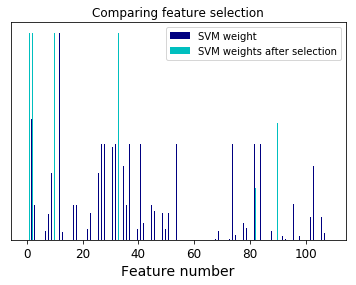

In [22]:
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy')

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='c')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [23]:
from sklearn import svm, datasets, feature_selection
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [24]:
transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

In [25]:
print(X.shape)
y_list = y.tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i][0])
y_array = np.array(y_new)
y_array.shape

(195, 110)


(195,)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  1   5   9  14  29  31  32  38  43  44  45  46  49  50  51  54  67  72
  73  74  76  81  83  88  96 100 102 104 106 107 108] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  6  10  11  16  18  19  24  25  34  37  39  40  42  66  78  80  82  84
  85  89  92  93  95  98 103 109] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  6  10  11  16  18  19  24  25  34  37  39  40  42  66  78  80  82  84
  85  89  92  93  95  98 103 109] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0  3  4  7 15 17 20 22 26 27 30 36 41 47 52 55 69 91] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


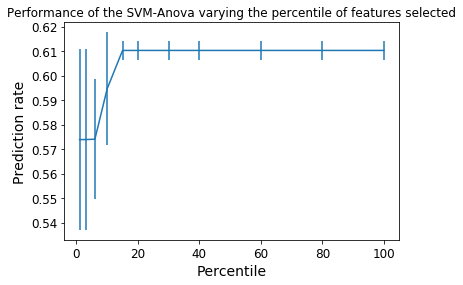

In [26]:
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y_array, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title('Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

# Multivariate analysis

In [27]:
from sklearn.model_selection import train_test_split
df4 = df3[['DIAGNOSIS', 'ADM_DAY', 'GENDER', 'DRG_CODE']].copy()
df4x = pd.get_dummies(df4)
X3 = df4x[['ADM_DAY_0.0', 'ADM_DAY_1.0', 'ADM_DAY_2.0', 'ADM_DAY_3.0', 'ADM_DAY_4.0', 'ADM_DAY_5.0', 'ADM_DAY_6.0']]

train_X3, test_X3 = train_test_split(X, test_size=0.2, random_state=42)

y3 = df3[['EXPIRE_FLAG']].copy()
train_y3, test_y3 = train_test_split(y, test_size=0.2, random_state=42)

In [28]:
y_list = test_y3.tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i][0])
test_y3 = np.array(y_new)

In [29]:
from sklearn.linear_model import LogisticRegression
lr_mn = LogisticRegression(multi_class='multinomial', solver ='newton-cg')
lr_mn.fit(train_X3, train_y3)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
from sklearn import metrics, cross_validation

preds = cross_validation.cross_val_predict(lr_mn, test_X3, test_y3, cv=10)
print (metrics.accuracy_score(test_y3, preds))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.487179487179


In [31]:
print (metrics.classification_report(test_y3, preds)) 

             precision    recall  f1-score   support

          0       0.12      0.07      0.09        14
          1       0.58      0.72      0.64        25

avg / total       0.42      0.49      0.44        39



=======================================
Receiver Operating Characteristic (ROC)
=======================================

Example of Receiver Operating Characteristic (ROC) metric to evaluate
classifier output quality.

ROC curves typically feature true positive rate on the Y axis, and false
positive rate on the X axis. This means that the top left corner of the plot is
the "ideal" point - a false positive rate of zero, and a true positive rate of
one. This is not very realistic, but it does mean that a larger area under the
curve (AUC) is usually better.

The "steepness" of ROC curves is also important, since it is ideal to maximize
the true positive rate while minimizing the false positive rate.

Multiclass settings
-------------------

ROC curves are typically used in binary classification to study the output of
a classifier. In order to extend ROC curve and ROC area to multi-class
or multi-label classification, it is necessary to binarize the output. One ROC
curve can be drawn per label, but one can also draw a ROC curve by considering
each element of the label indicator matrix as a binary prediction
(micro-averaging).

Another evaluation measure for multi-class classification is
macro-averaging, which gives equal weight to the classification of each
label.

In [32]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
random_state = np.random.RandomState(42)

In [33]:
# Convert to Binarize formatting
yy = y3.applymap(int).as_matrix()
y4 = label_binarize(yy, classes=[0, 1])
n_classes = y.shape[1]

In [34]:
# shuffle and split training and test sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X3, y4, test_size=.3,
                                                    random_state=42)
n_classes = y4.shape[1]

In [36]:
# Learn to predict each class against the other
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y4_score = classifier.fit(X4_train, y4_train).decision_function(X4_test)

In [38]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y4_test[:, i], y4_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [39]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y4_test.ravel(), y4_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

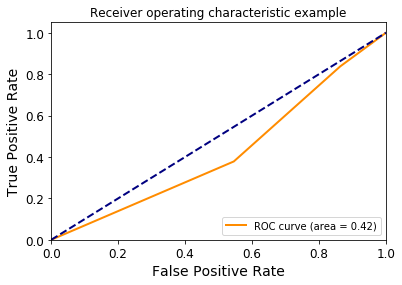

In [47]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

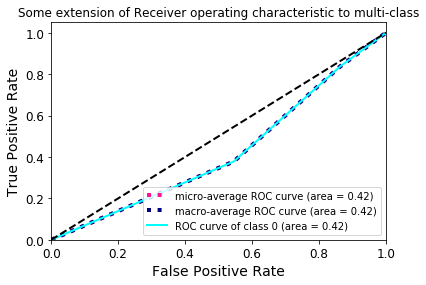

In [48]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [105]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y4_test, y4_score)

0.42199017199017197


=============================================================
Receiver Operating Characteristic (ROC) with cross validation
=============================================================

Example of Receiver Operating Characteristic (ROC) metric to evaluate
classifier output quality using cross-validation.

ROC curves typically feature true positive rate on the Y axis, and false
positive rate on the X axis. This means that the top left corner of the plot is
the "ideal" point - a false positive rate of zero, and a true positive rate of
one. This is not very realistic, but it does mean that a larger area under the
curve (AUC) is usually better.

The "steepness" of ROC curves is also important, since it is ideal to maximize
the true positive rate while minimizing the false positive rate.

This example shows the ROC response of different datasets, created from K-fold
cross-validation. Taking all of these curves, it is possible to calculate the
mean area under curve, and see the variance of the curve when the
training set is split into different subsets. This roughly shows how the
classifier output is affected by changes in the training data, and how
different the splits generated by K-fold cross-validation are from one another.

# import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [56]:
# Run classifier with cross-validation
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 195) # (change based on size of data being run)

In [75]:
y5 = y3.applymap(int) #change: make y values a one row matrix of ints
y_list = y5['EXPIRE_FLAG'].tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i])
y5 = np.array(y_new)

In [90]:
X5 = X3.applymap(int).as_matrix() #change: make X values a matrix of ints
n_samples, n_features = X5.shape 

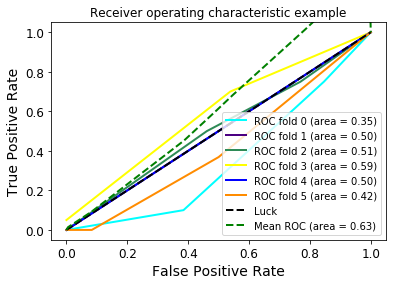

In [98]:
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X5, y5), colors):
    probas_ = classifier.fit(X5[train], y5[train]).predict_proba(X5[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y5[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', 
         label='Luck')

mean_tpr /= cv.get_n_splits(X5, y5)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()